In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchinfo import summary
from numpy.typing import NDArray

train_batches = []
for i in range(1, 6):
    with open(f"./cifar-10-batches-py/data_batch_{i}", "rb") as f:
        train_batches.append(pickle.load(f, encoding="bytes"))

with open("./cifar-10-batches-py/test_batch", "rb") as f:
    test_batch = pickle.load(f, encoding="bytes")

with open ("./cifar-10-batches-py/batches.meta", "rb") as f:
    label_names = pickle.load(f)["label_names"]

In [2]:
print(test_batch[b'labels'])
print(train_batches[0][b'data'][0])

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 6, 8, 6, 8, 0, 4, 0, 7, 7, 5, 5, 3, 5, 2, 3, 4, 1, 7, 5, 4, 6, 1, 9, 3, 

In [3]:
print(train_batches[0][b'data'].shape)

train_imgs = np.concatenate([batch[b'data'] for batch in train_batches], dtype=np.float32) \
    .reshape(-1, 3, 32, 32) \
    .transpose(0, 2, 3, 1) / 255
print(train_imgs.shape)

train_labels: NDArray[np.int8] = np.concatenate(
    [batch[b'labels'] for batch in train_batches], dtype=np.int8)
print(train_labels.shape)
print(train_labels)

test_imgs: NDArray[np.float32] = test_batch[b'data'] \
    .reshape(-1, 3, 32, 32) \
    .transpose(0, 2, 3, 1) / 255
print(test_imgs.shape)

labels_map = {i: label for i, label in enumerate(label_names)}
print(labels_map)

(10000, 3072)
(50000, 32, 32, 3)
(50000,)
[6 9 9 ... 9 1 1]
(10000, 32, 32, 3)
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


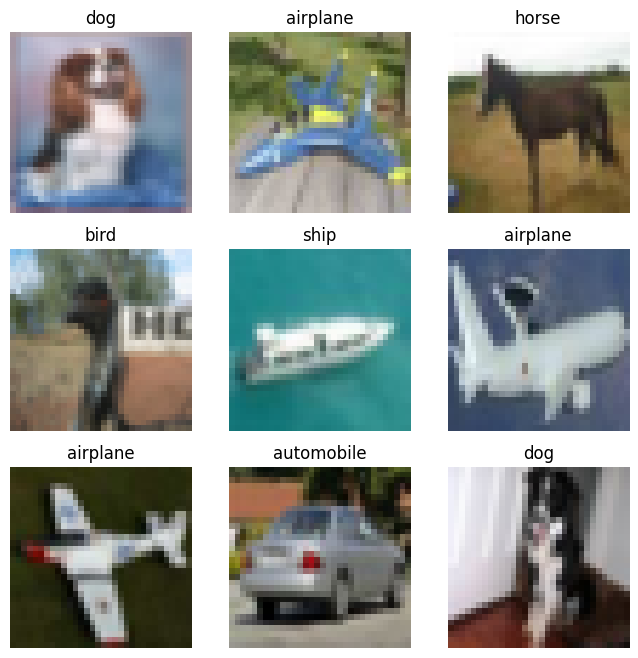

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_imgs), size=(1,)).item()
    label = train_labels[sample_idx]
    img = train_imgs[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
from numpy import mean
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from PIL import Image

# all_transforms = transforms.Compose([transforms.Resize((48, 48)),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
#                                                           std=[0.2023, 0.1994, 0.2010])
#                                      ])
# Copied from: https://www.kaggle.com/code/ayushnitb/cifar10-custom-resnet-cnn-pytorch-97-acc
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
composed_train = transforms.Compose([ transforms.Resize((32, 32)),  # Resize the image in a 32X32 shape
                                     # Randomly rotate some images by 20 degrees
                                     transforms.RandomRotation(20),
                                     # Randomly horizontal flip the images
                                     transforms.RandomHorizontalFlip(0.1),
                                     transforms.ColorJitter(brightness=0.1,  # Randomly adjust color jitter of the images
                                                            contrast=0.1,
                                                            saturation=0.1),
                                     transforms.RandomAdjustSharpness(sharpness_factor=2,
                                                                      p=0.1),  # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     # Normalizing with standard mean and standard deviation
                                     transforms.Normalize(mean, std),
                                     transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0, inplace=False)])


composed_test = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

# train_dataset2 = torchvision.datasets.CIFAR10(root='./temp_data',
#                                               train=True,
#                                               transform=all_transforms,
#                                               download=True)


def get_mean_std(imgs: NDArray[np.float32]) -> tuple[float, float]:
    n, h, w, c = imgs.shape
    num_pixles = n * h * w
    mean = np.sum(imgs) / num_pixles
    std = np.sum((imgs - mean) ** 2) / num_pixles

    return mean, std


class CF10Dataset(Dataset):
    def __init__(self, imgs: NDArray[np.float32], labels: NDArray[np.int8], trnsfrms: transforms.Compose) -> None:
        self.labels = []
        # mean, std = get_mean_std(imgs)
        print(mean, std)
        # convert imgs to torchvision images
        self.imgs = []
        for img, label in zip(imgs, labels):
            for i in range(3):
                self.imgs.append(trnsfrms(Image.fromarray((img * 255).astype(np.uint8))))
                self.labels.append(label)

    def __len__(self) -> int:
        return len(self.imgs)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        img = self.imgs[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.uint8)
        return img, label

In [6]:
from torch.utils.data import DataLoader
import time

train_dataset = CF10Dataset(train_imgs, train_labels, composed_train)
device = 'cuda'

print(len(train_dataset))

[0.4914, 0.4822, 0.4465] [0.2023, 0.1994, 0.201]
150000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5771239].


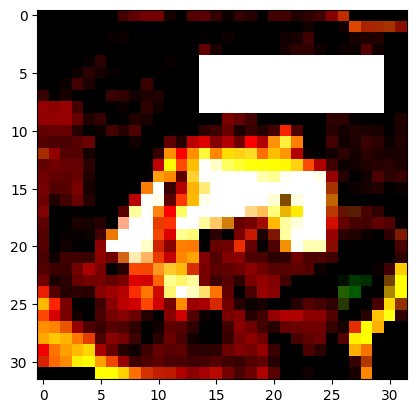

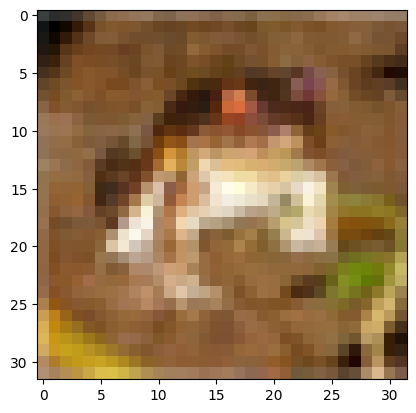

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.351526..2.4220564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..1.1414441].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.265974].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..1.9519254].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657.

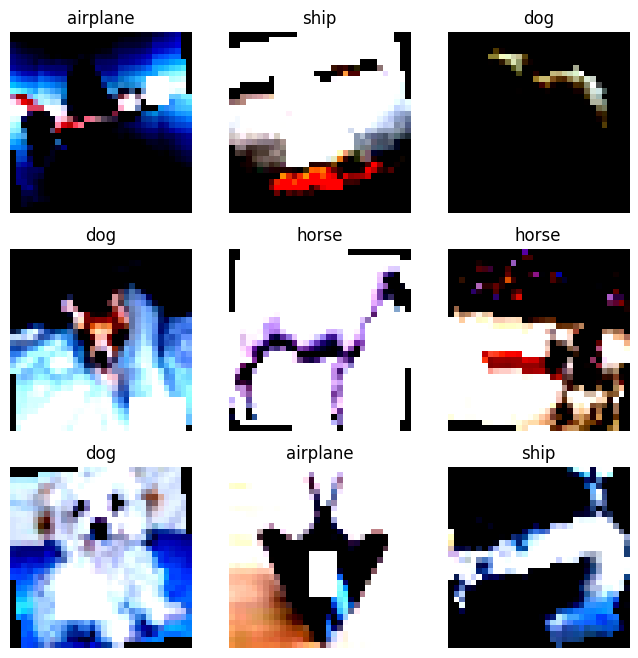

In [7]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0))
plt.show()

plt.imshow(train_imgs[0])
plt.show()

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = int(torch.randint(len(train_imgs), size=(1,)).item())
    label = train_dataset[sample_idx][1].item()
    img = train_dataset[sample_idx][0].permute(1, 2, 0)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [31]:
def init_weights(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
  elif isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight)

class CustomVGG19(nn.Module):
    def __init__(self, num_classes, input_size):
        super(CustomVGG19, self).__init__()

        self.conv1_1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU())
        self.conv1_2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU())
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU())
        self.conv2_2 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU())
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU())
        self.conv3_2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU())  
        self.conv3_3 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU())
        self.conv3_4 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU())
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU())
        self.conv4_2 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU())
        self.conv4_3 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU())
        self.conv4_4 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU())
        self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU())
        self.conv5_2 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU())
        self.conv5_3 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU())
        self.conv5_4 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU())
        self.max_pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(nn.Linear(512 * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5))
        self.fc2 = nn.Sequential(nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5))
        self.fc3 = nn.Linear(4096, num_classes)


    def forward(self, input):
        out = self.conv1_1(input)
        out = self.conv1_2(out)
        out = self.max_pool1(out)

        out = self.conv2_1(out)
        out = self.conv2_2(out)
        out = self.max_pool2(out)

        out = self.conv3_1(out)
        out = self.conv3_2(out)
        out = self.conv3_3(out)
        out = self.conv3_4(out)
        out = self.max_pool3(out)

        out = self.conv4_1(out)
        out = self.conv4_2(out)
        out = self.conv4_3(out)
        out = self.conv4_4(out)
        out = self.max_pool4(out)

        out = self.conv5_1(out)
        out = self.conv5_2(out)
        out = self.conv5_3(out)
        out = self.conv5_4(out)
        out = self.max_pool5(out)

        out = self.adaptive_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out)

        return out

test = CustomVGG19(10, 32)
summary(test, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CustomVGG19                              [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 64, 32, 32]           36,928
│    └─ReLU: 2-4                         [1, 64, 32, 32]           --
├─MaxPool2d: 1-3                         [1, 64, 16, 16]           --
├─Sequential: 1-4                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-5                       [1, 128, 16, 16]          73,856
│    └─ReLU: 2-6                         [1, 128, 16, 16]          --
├─Sequential: 1-5                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-7                       [1, 128, 16, 16]          147,584

In [17]:
from torchvision.models import vgg19
vg = vgg19(num_classes=10)

summary(vg, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 64, 32, 32]           36,928
│    └─ReLU: 2-4                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 128, 16, 16]          73,856
│    └─ReLU: 2-7                         [1, 128, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 128, 16, 16]          147,584
│    └─ReLU: 2-9                         [1, 128, 16, 16]          --
│    └─MaxPool2d: 2-10                   [1, 128, 8, 8]            --
│    └─Conv2d: 2-11                      [1, 256, 8, 8]            29

In [11]:
def test_model(model, loader: DataLoader):
    with torch.no_grad():
        correct = 0
        total = 0
        predictions = []
        correct_preds = []
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    correct_preds.append(predicted[i])
        
        print('Accuracy of the network on the {} train images: {} %'.format(50000, 100 * correct / total))

In [34]:
from torch.optim import SGD
from torchvision.models import vgg16
torch.cuda.empty_cache()

train_loader = DataLoader(train_dataset, batch_size=200, num_workers=4, shuffle=True)

learning_rate = 0.01

model = CustomVGG19(10, 32).to(device)
# model = vgg19(num_classes=10).to(device)
# model = vgg16().to(device)
# model = SmallConvNet(10).to(device)
# model = SmallVGG19(10, 32).to(device)

model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001, momentum=0.9)

num_epochs = 50

losses = []
accs = []


In [35]:
for epoch in range(num_epochs):
    start = time.time()
    epoch_loss = 0
    epoch_acc = 0
    num_batches = len(train_loader)
    
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Accumulate loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += (outputs.argmax(1) == labels).float().mean().item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches
    losses.append(avg_loss)
    accs.append(avg_acc)
    
    end = time.time()
    
    print('Epoch [{}/{}], tt: {:.2f} Loss: {:.4f} Acc: {:.2f}'.format(epoch+1, num_epochs, end - start, avg_loss, avg_acc))

Epoch [1/50], tt: 18.19 Loss: 1.6776 Acc: 0.37
Epoch [2/50], tt: 18.23 Loss: 1.1602 Acc: 0.58
Epoch [3/50], tt: 18.26 Loss: 0.9074 Acc: 0.68
Epoch [4/50], tt: 18.27 Loss: 0.7397 Acc: 0.75
Epoch [5/50], tt: 18.22 Loss: 0.6063 Acc: 0.79
Epoch [6/50], tt: 18.32 Loss: 0.5026 Acc: 0.83
Epoch [7/50], tt: 18.38 Loss: 0.4148 Acc: 0.86
Epoch [8/50], tt: 18.32 Loss: 0.3426 Acc: 0.88
Epoch [9/50], tt: 18.38 Loss: 0.2807 Acc: 0.90
Epoch [10/50], tt: 18.26 Loss: 0.2291 Acc: 0.92
Epoch [11/50], tt: 18.27 Loss: 0.1837 Acc: 0.94
Epoch [12/50], tt: 18.32 Loss: 0.1504 Acc: 0.95
Epoch [13/50], tt: 18.33 Loss: 0.1256 Acc: 0.96
Epoch [14/50], tt: 18.31 Loss: 0.1045 Acc: 0.96
Epoch [15/50], tt: 18.27 Loss: 0.0920 Acc: 0.97
Epoch [16/50], tt: 18.29 Loss: 0.0760 Acc: 0.97
Epoch [17/50], tt: 18.26 Loss: 0.0719 Acc: 0.98
Epoch [18/50], tt: 18.31 Loss: 0.0554 Acc: 0.98
Epoch [19/50], tt: 18.26 Loss: 0.0551 Acc: 0.98
Epoch [20/50], tt: 18.29 Loss: 0.0470 Acc: 0.98
Epoch [21/50], tt: 18.32 Loss: 0.0445 Acc: 0.98
E

KeyboardInterrupt: 

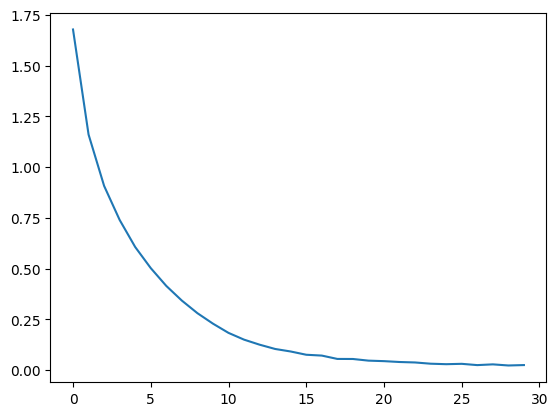

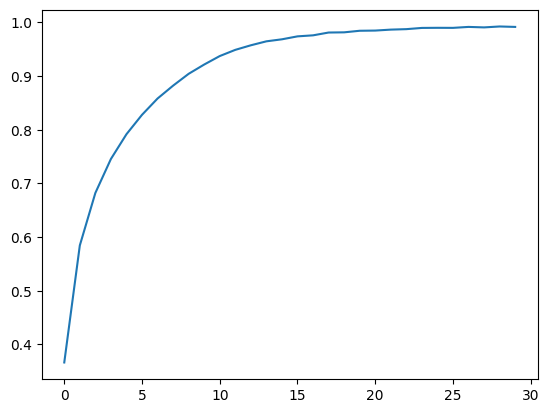

In [36]:
plt.plot(losses, label='loss')
plt.show()
plt.plot(accs, label='accuracy')
plt.show()

In [37]:
test_loader = DataLoader(CF10Dataset(test_imgs, test_batch[b'labels'], composed_test), batch_size=2500, num_workers=2, shuffle=True)
print(test_model(model, test_loader))

[0.4914, 0.4822, 0.4465] [0.2023, 0.1994, 0.201]
Accuracy of the network on the 50000 train images: 83.25666666666666 %
None
